# Melodic Extraction

> automatically estimating the pitch sequence of the melody directly from the audio signal ... [1]




## Paiva's algorithm
> Our system comprises three main modules: pitch detection, de- termination of musical notes (with precise temporal boundaries, pitches, and intensity levels), and identification of melodic notes.... Generally, most current systems, including ours, are based on a front-end for frequency analysis (e.g., Fourier Transform, autocorrelation, auditory models, multi-rate filterbanks, or Bayesian frameworks), peak-picking and tracking (in the magnitude spectrum, in a summary autocorrelation function, or in a pitch probability density function), and postprocessing for melody identification (primarily rulebased approaches based on perceptual rules of sound organization, musicological rules, path-finding in networks of notes, etc.). One exception is Poliner and Ellis (2005), where the authors follow a different strategy by approaching the melody-detection prob- lem as a classification task using Support Vector Machines. [2]


## Melody
we define melody as ''the domi- nant individual pitched line in a musical ensemble.'' Also, we define “line” as a sequence of musical notes, each characterized by specific temporal boundaries as well as a corresponding MIDI note number and intensity level [2]

[1] J. Salamon. Melody Extraction from Polyphonic Music Signals. PhD thesis, Universitat Pompeu Fabra, Barcelona, Spain, 2013.]

[2] Rui Pedro Paiva, Teresa Mendes, and AmA ̃lcar Cardoso. Melody detection in polyphonic musical signals: Exploiting perceptual rules, note salience and melodic smoothness. Computer Music Journal, 30:80–98, 12 2006.

# Extra

http://ismir2004.ismir.net/melody_contest/results.html

# Algorithm Structure

1. Segmenting audio based on Onset Detetion : this allows us to reduce the scope of the frequency analysis and enhance accuracy.

2. Estimating the fundamental frequency of the segments
  1. autocorrelation
  2. dft estimation

3. Concatenating the f0 estimates into an array of the same length as the original sound file

In [5]:
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
import glob
drive.mount('/content/drive')
from ipywidgets import interact

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load an audio file

In [6]:
filename = "/content/drive/MyDrive/python_scratch/audio/newfiles/audio/simple_piano.wav"
y, sr = librosa.load(filename, duration=3)
ipd.Audio(y, rate=sr)

# Detect Onsets
## Librosa's Onset Detection


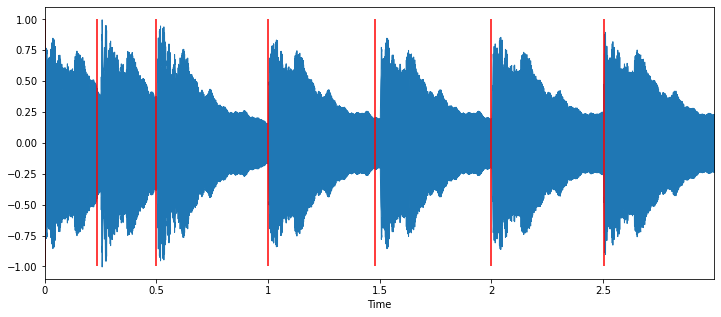

In [7]:
hop_length=128
onset_samples = librosa.onset.onset_detect(y,
                                           sr=sr,
                                           units='samples', 
                                           hop_length=hop_length, 
                                           backtrack=True,
                                           pre_max=20,
                                           post_max=20,
                                           pre_avg=100,
                                           post_avg=100,
                                           delta=0.2,
                                           wait=0)
# optionally adjust edges
onsets_borders = np.concatenate([ [0], onset_samples, [len(y)] ]).astype(np.int64)
# convert to time units
onsets_times = librosa.samples_to_time(onsets_borders, sr=sr)
# plot waveform
librosa.display.waveplot(y, sr=sr, x_axis='time')
# plot red vertical lines
plt.vlines(onsets_times, -1, 1, colors='r')
plt.rcParams['figure.figsize'] = (12, 5)

## Segment the Audio

Split the audio file into segments

In [8]:
# segments = []

# # loop through every element in the onset array
# for ...
# # get the lower bound
# start = 
# # get the upper bound
# end = 
# # trim the audio array with the new bounds
# trimmed = 
# # append to a list
# segments.append...

# # listen to the concatenated (it has to sound like the original, unchanged)
# ipd.Audio(np.concatenate(segments), rate=sr)

In [9]:
#@title solution
segments = []

for i in range(len(onsets_borders)-1):
    # get segment bounds
    start = onsets_borders[i] 
    end =  onsets_borders[i+1]
    # get segment
    segment = y[start:end]
    # add segment to the list
    segments.append(segment)

ipd.Audio(np.concatenate(segments), rate=sr)

In [10]:
# frame_sz = sr // 10
# segments = np.array([y[i:i+frame_sz] for i in onsets_borders])
# segments = [ y[onsets_borders[i]:onsets_borders[i+1]] for i in range(len(onsets_borders)-1) ]

Here is a function that adds 300 ms of silence onto the end of each segment and concatenates them into one signal.

Later, we will use this function to listen to each segment, perhaps sorted in a different order.

In [11]:
def concatenate_segments(segments, sr=22050, pad_time=0.300):
    
    silence = np.zeros(int( pad_time * sr))
    
    padded = []

    for segment in segments:
        
        pad = np.concatenate([segment, silence])
        padded.append(pad)
    
    return np.concatenate(padded)

Listen to the newly concatenated signal.

In [12]:
ipd.Audio(concatenate_segments(segments, sr), rate=sr)

## Fundamental Frequency Estimation
### 1. Autocorrelation Method

In [13]:
def f0_estimate(x, sr=22050, midi_lo=12., midi_hi=120.):
    """
    Find the location of the maximum autocorrelation.
    """
    r = librosa.autocorrelate(x, max_size=5000)

    
    # only to search within a range of reasonable pitches:
    f_hi = librosa.midi_to_hz(midi_hi)
    f_lo = librosa.midi_to_hz(midi_lo)
    t_lo = sr/f_hi
    t_hi = sr/f_lo
    
    # Set invalid pitch candidates to zero:
    r[:int(t_lo)] = 0
    r[int(t_hi):] = 0

    return float(sr)/r.argmax() if r.any() else -1

## run the function and estimate

In [14]:
librosa.hz_to_note(f0_estimate(segments[2]))

'A4'

# Exercise
Make a for loop to compute the NOTE value using `librosa.hz_to_note` of all segments

In [15]:
allnotes = [ librosa.hz_to_note(f0_estimate(s)) for s in segments ]
print(allnotes)

['F4', 'G4', 'A4', 'G4', 'G4', 'F4', 'E4']


Now, Use the `generate_tone` function below to modify your for loop so as to return a "tones" array with all the tones instead of segments

In [16]:
def generate_tone(f0, sr, n_duration):
    n = np.arange(n_duration)
    return 0.1 * np.sin(2*np.pi*f0*n/float(sr))

In [17]:
tones = [ generate_tone(f0_estimate(s), sr, len(s) ) for s in segments ]
ipd.Audio(np.concatenate(tones), rate=sr)

In [18]:
#@title solution
tones = []
for i in segments:
    estimate = f0_estimate(i)
    tone = generate_tone(estimate, sr, len(i))
    tones.append(tone)
ipd.Audio(np.concatenate(tones), rate=sr)

## 2. DFT f0 Estimation method

In [19]:
def dft_estimate(x, sr=22050):
    # compute the DFT of the onset strength envelope
    p = np.fft.fft(x)
    # p = np.fft.fft(custom_onset_strength)
    # get rid of second half (symmetrical), and the first element
    half_length = p.shape[0]//2
    pabs_half = p[1:half_length-1]
    # compute the power spectrum
    pabs = np.abs(pabs_half)**2
    # # normalize
    # pabs -= pabs.min()
    # # pabs /= np.linalg.norm(pabs)
    # pabs /= pabs.max()

    freqs = librosa.fft_frequencies(sr=sr,n_fft=len(x))

    return freqs[pabs.argmax()]

# Exercise
use the dft_estimate function instead of the autocorrelation to generate another tones array called `dft_estimation_tones` and compare

In [20]:
dft_estimation_notes = [ librosa.hz_to_note(dft_estimate(s)) for s in segments ]
print(dft_estimation_notes)

['F4', 'G4', 'A4', 'G4', 'G4', 'F4', 'E4']


In [21]:
dft_estimation_tones = [ generate_tone(dft_estimate(s), sr, len(s) ) for s in segments ]
ipd.Audio(np.concatenate(dft_estimation_tones),rate=sr)

In [22]:
ipd.Audio(np.concatenate(tones), rate=sr)

In [23]:
[ (dft_estimate(s),f0_estimate(s)) for s in segments ]

[(344.53125, 350.0),
 (385.7252038043478, 393.75),
 (436.67332848837214, 441.0),
 (388.1165286144579, 393.75),
 (389.04933286516854, 393.75),
 (346.5113146551724, 350.0),
 (327.2764523766163, 329.1044776119403)]

In [24]:
ipd.Audio(y*0.07 + np.concatenate(tones), rate=sr)

# Constant Q-Transform

The [constant-Q transform](https://en.wikipedia.org/wiki/Constant-Q_transform), simply known as **CQT** transforms a data series to the frequency domain. It is related to the Fourier transform...  can be thought of as a series of filters logarithmically spaced in frequency.



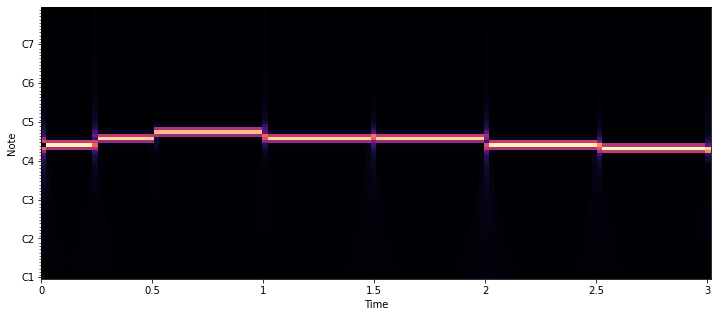

In [25]:
cqt = librosa.cqt(np.concatenate(tones), sr=sr)
librosa.display.specshow(abs(cqt), sr=sr, x_axis='time', y_axis='cqt_note')

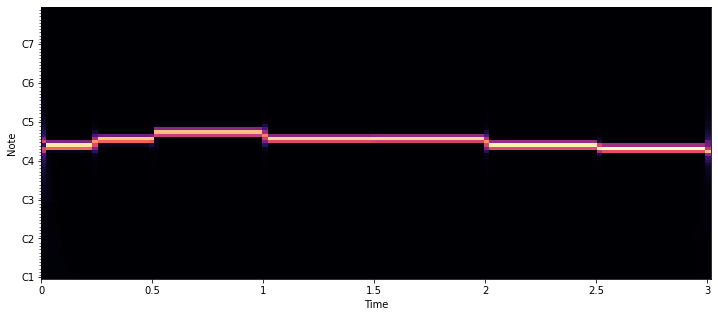

In [26]:
f0_cqt = librosa.cqt(np.concatenate(dft_estimation_tones), sr=sr)
librosa.display.specshow(abs(f0_cqt), sr=sr, x_axis='time', y_axis='cqt_note')

In [ ]:
!apt-get install musescore
!apt-get install xvfb
import os
os.putenv('DISPLAY', ':99.0')
!start-stop-daemon --start --pidfile /var/run/xvfb.pid --make-pidfile --background --exec /usr/bin/Xvfb -- :99 -screen 0 1024x768x24 -ac +extension GLX +render -noreset
from music21 import *
us = environment.UserSettings()
us['musescoreDirectPNGPath'] = '/usr/bin/mscore'
us['directoryScratch'] = '/tmp'
!sh -e /etc/init.d/x11-common start


In [110]:
import re

def octave(note,octave):
    # CC to BB = from C below bass clef to second-line B in bass clef
    # C to B = from bass clef C to B below middle C.
    # c  to b = from middle C to the middle of treble clef
    # c' to b' = from C in treble clef to B above treble clef
    if octave <= '2':
        return note.upper()+note.upper()
    elif octave <= '3':
        return note.upper()
    elif octave <= '4':
        return note.lower()
    else:
        return note.lower()+"'"

def get_notes(notes):
    return [octave(re.sub("[0-9]", "", n),re.sub("[^0-9]", "", n)) for n in notes]

note_array = get_notes(dft_estimation_notes)
print(note_array)
# test_notes = ["a4","c2","f3","g3","g5"]
# tests = get_notes(test_notes)
# print(tests)

['f', 'g', 'a', 'g', 'g', 'f', 'e']


In [111]:
bpm = librosa.beat.tempo(y,sr=sr)
def get_quarterLength(notes,bpm):
    # this is not accurate?
    notes = round(notes,ndigits=4)
    if notes <= 60/bpm:
        return "8"
    elif notes <= 60/bpm/3:
        return "8."
    else:
        return "4"

note_names = " ".join([
                       n + get_quarterLength(len(s)/sr,bpm) 
                       for s, n in zip(segments, 
                                       get_notes(dft_estimation_notes))
                       ])
print(bpm, 60/bpm)
print(note_names)

[123.046875] [0.48761905]
f8 g8 a4 g8 g4 f4 e4


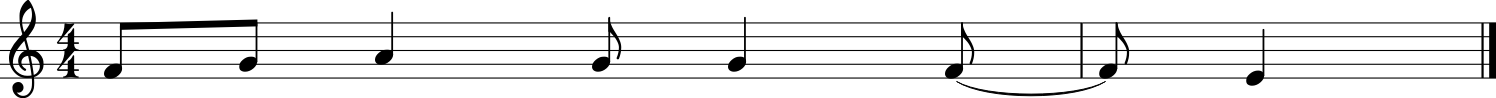

In [112]:
littleMelody = converter.parse(f"tinynotation: 4/4 {note_names}")
littleMelody.show()

In [ ]:
#@title Default title text
# folder = "mirex05TrainFiles"
folder = "SVNote1"
for f in [ i for i in glob.glob(f"/content/drive/MyDrive/python_scratch/audio/{folder}/*.wav")]:
    y, sr = librosa.load(f, duration=10)
    b = onsets(y)
    segments = [ y[b[i]:b[i+1]] for i in range(len(b)-1) ]
    tones = [generate_tone(dft_estimate(s),sr,len(s)) for s in segments]
    print(f)
    display(ipd.Audio(np.concatenate(tones)+y*0.1, rate=sr))